# Visualization of outbreaks and simulation results

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'nursing_home')
from model_nursing_home import SEIRX_nursing_home

## Simulations

### Run simulations to create data

In [5]:
sim_name = 'outbreak_size_calibration'

# simulation settings correspond to the situation at the homes at the point in
# time at which the outbreaks happened (i.e. PCR tests with two-day turnover
# used for diagnostic testing, no preventive screening)

N_steps = 60
verbosity = 0
runs = 1000
G = nx.readwrite.gpickle.read_gpickle('../data/interactions_single_quarter.gpickle')
N_residents = len(G.nodes)
agent_types = {
    'employee':{'screening_interval': None,
                'index_probability': 0,
                'transmission_risk': 0.0275,
                'reception_risk': 1,
                'symptom_probability': 0.6},
    
    'resident':{'screening_interval': None,
                'index_probability': 0,
                'transmission_risk': 0.0275,
                'reception_risk': 1,
                'symptom_probability': 0.6},
}

results = pd.DataFrame()
for j in range(runs):
    model = SEIRX_nursing_home(G, verbosity, testing=True,
                  diagnostic_test_type = 'two_day_PCR',
                  preventive_screening_test_type = None,
                  agent_types=agent_types)

    for i in range(N_steps):
        if verbosity > 0: 
            print()
            print('*** step {} ***'.format(i+1))
        model.step()
        
    data = model.datacollector.get_model_vars_dataframe()
    data['run'] = j
    # get the simulation data from the point in time at whicht he first test
    # result arrived minus two days. We include the two preceding days to get a
    # nicer view of what happened before "day zero" in the plot.
    # In rare cases (if the outbreak did not cause follow-up cases 
    # and was asymptomatic, there will be no diagnostic test. We discard these
    # cases)
    try:
        data = data.loc[data[data['N_diagnostic_tests'] > 0].index[0]:]
    except IndexError:
        pass
    # introduce a "shifted" time-step that is zero at the day the first test 
    # result arrived. Since the simulation stores the time a test occured
    # and in the case of PCR tests with a two-day turnover, it takes two
    # additional days for results to arrive, we need to shift the time-step
    # by two days (corresponding to the test turnover-time)
    data['shifted_step'] = range(-2, len(data) - 2)
    results = pd.concat([results, data])
results = results.reset_index(drop=True)

results.to_csv('../data/{}_N{}.csv'.format(sim_name, runs), index=False)

### Transform observables to match observed cases in homes

In [6]:
sim_name = 'outbreak_size_calibration'
runs = 1000
results = pd.read_csv('../data/{}_N{}.csv'.format(sim_name, runs))
                      
# combine the number of infected and recovered to calculate the number of 
# overall infected cumulated over time
results['cumulative_I_employee'] = results['I_employee'] + results['R_employee']
results['cumulative_I_resident'] = results['I_resident'] + results['R_resident']

# average over all simulation runs
mean_res = results[['shifted_step', 'cumulative_I_employee', 'cumulative_I_resident']]\
    .groupby('shifted_step')\
    .agg({'cumulative_I_employee':['mean', 'std'], 'cumulative_I_resident':['mean', 'std']})\
    .reset_index()

## Load outbreak case data

In [6]:
!ls ../data/nursing_home

interactions_2_quarters.bz2	 oubreak_2.csv
interactions_3_quarters.bz2	 oubreak_3.csv
interactions_4_quarters.bz2	 oubreak_4.csv
interactions_single_quarter.bz2  outbreak_size_calibration_N1000.csv
oubreak_1.csv			 simulation_results_N10000.csv


In [7]:
df_case1 = pd.read_csv('../data/nursing_home/oubreak_1.csv')
df_case2 = pd.read_csv('../data/nursing_home/oubreak_2.csv')
df_case3 = pd.read_csv('../data/nursing_home/oubreak_3.csv')
df_case4 = pd.read_csv('../data/nursing_home/oubreak_4.csv')

## Visualize the outbreak data

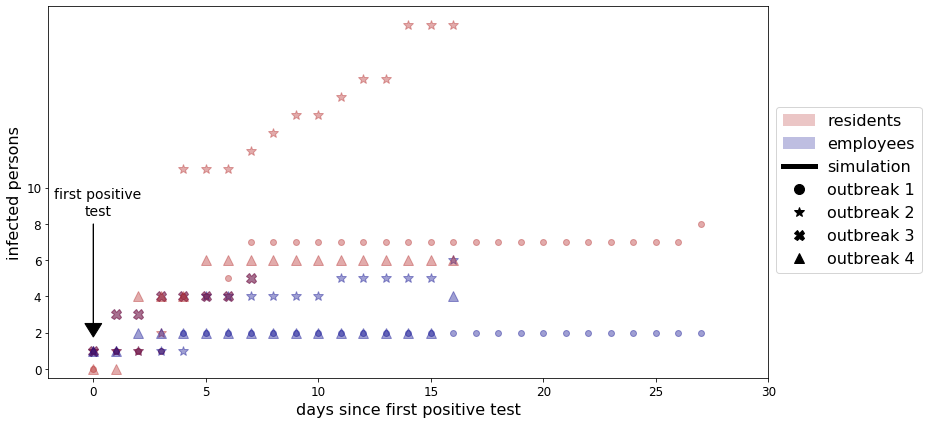

In [12]:
fig, ax = plt.subplots(figsize=(13, 6))
alpha=0.25

# cases
ax.plot(df_case1['t'], df_case1['cumulative_I_employee'], 'o', color='DarkBlue',
        alpha=alpha*1.5)
ax.plot(df_case1['t'], df_case1['cumulative_I_resident'], 'o', color='FireBrick',
        alpha=alpha*1.5)

ax.plot(df_case2['t'], df_case2['cumulative_I_employee'], '*', color='DarkBlue',
        alpha=alpha*1.5, markersize=10)
ax.plot(df_case2['t'], df_case2['cumulative_I_resident'], '*', color='FireBrick',
        alpha=alpha*1.5, markersize=10)

ax.plot(df_case3['t'], df_case3['cumulative_I_resident'], 'X', color='DarkBlue',
        alpha=alpha*1.5, markersize=10)
ax.plot(df_case3['t'], df_case3['cumulative_I_resident'], 'X', color='FireBrick',
        alpha=alpha*1.5, markersize=10)

ax.plot(df_case4['t'], df_case4['cumulative_I_employee'], '^', color='DarkBlue',
        alpha=alpha*1.5, markersize=10)
ax.plot(df_case4['t'], df_case4['cumulative_I_resident'], '^', color='FireBrick',
        alpha=alpha*1.5, markersize=10)

ax.set_xlim(-2, 30)
ax.set_ylim(-0.5, 20)
ax.set_yticks(range(0, 11, 2))
ax.set_yticklabels(range(0, 11, 2), fontsize=12)
ax.set_xticks(range(0, 31, 5))
ax.set_xticklabels(range(0, 31, 5), fontsize=12)
ax.set_xlabel('days since first positive test', fontsize=16)
ax.set_ylabel('infected persons', fontsize=16)

# legend
from matplotlib.patches import Patch
res_handle = Patch(facecolor='FireBrick',label='residents', alpha=alpha)
emp_handle = Patch(facecolor='DarkBlue',label='employees', alpha=alpha)

sim_handle = plt.Line2D((0,1),(0,0), color='k', linewidth=5)
case1_handle = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='',
                          markersize=10)
case2_handle = plt.Line2D((0,1),(0,0), color='k', marker='*', linestyle='',
                          markersize=10)
case3_handle = plt.Line2D((0,1),(0,0), color='k', marker='X', linestyle='',
                          markersize=10)
case4_handle = plt.Line2D((0,1),(0,0), color='k', marker='^', linestyle='',
                          markersize=10)

legend = ax.legend([res_handle, emp_handle, sim_handle, case1_handle, case2_handle,
           case3_handle, case4_handle],
          ['residents', 'employees', 'simulation', 'outbreak 1', 'outbreak 2',
           'outbreak 3', 'outbreak 4'],
           fontsize=16, loc=2, bbox_to_anchor=[1, 0.75])

# indicator line for first positive test
ax.arrow(0, 8, 0, -5.5, head_width=0.75, head_length=0.75, facecolor='k')
ax.text(0.2, 8.5, 'first positive\ntest', fontsize=14, ha='center')

fig.tight_layout()
plt.savefig('../img/outbreak_calibration.pdf')

In [10]:
df_case2

,t,cumulative_I_employee,cumulative_I_resident
0,0,1,1
1,1,1,1
2,2,1,1
3,3,1,2
4,4,1,11
5,5,4,11
6,6,4,11
7,7,4,12
8,8,4,13
9,9,4,14


## Visualize the simulation- and outbreak data

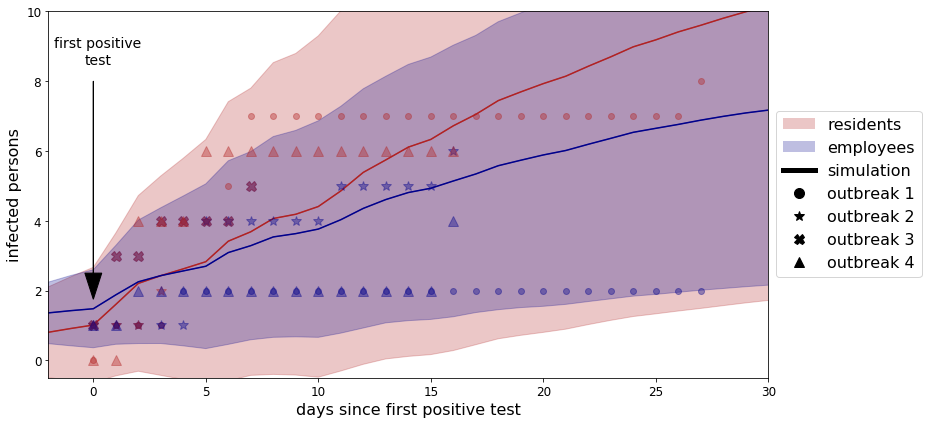

In [9]:
fig, ax = plt.subplots(figsize=(13, 6))
#ax.grid('on', color='k', linewidth=0.1)

alpha = 0.25

I_res = mean_res[('cumulative_I_resident', 'mean')]
I_res_std = mean_res[('cumulative_I_resident', 'std')]
I_emp = mean_res[('cumulative_I_employee', 'mean')]
I_emp_std = mean_res[('cumulative_I_employee', 'std')]

# simulations
ax.plot(mean_res['shifted_step'], I_res, color='FireBrick', label='residents')
ax.plot(mean_res['shifted_step'], I_emp, color='DarkBlue', label='employees')

ax.fill_between(mean_res['shifted_step'], I_res, I_res - I_res_std, \
                color='FireBrick', alpha=alpha)
ax.fill_between(mean_res['shifted_step'], I_res, I_res + I_res_std, \
                color='FireBrick', alpha=alpha)

ax.fill_between(mean_res['shifted_step'], I_emp, I_emp - I_emp_std, \
                color='DarkBlue', alpha=alpha)
ax.fill_between(mean_res['shifted_step'], I_emp, I_emp + I_emp_std, \
                color='DarkBlue', alpha=alpha)

# cases
ax.plot(df_case1['t'], df_case1['cumulative_I_employee'], 'o', color='DarkBlue',
        alpha=alpha*1.5)
ax.plot(df_case1['t'], df_case1['cumulative_I_resident'], 'o', color='FireBrick',
        alpha=alpha*1.5)

ax.plot(df_case2['t'], df_case2['cumulative_I_employee'], '*', color='DarkBlue',
        alpha=alpha*1.5, markersize=10)
ax.plot(df_case2['t'], df_case2['cumulative_I_resident'], '*', color='FireBrick',
        alpha=alpha*1.5, markersize=10)

ax.plot(df_case3['t'], df_case3['cumulative_I_resident'], 'X', color='DarkBlue',
        alpha=alpha*1.5, markersize=10)
ax.plot(df_case3['t'], df_case3['cumulative_I_resident'], 'X', color='FireBrick',
        alpha=alpha*1.5, markersize=10)

ax.plot(df_case4['t'], df_case4['cumulative_I_employee'], '^', color='DarkBlue',
        alpha=alpha*1.5, markersize=10)
ax.plot(df_case4['t'], df_case4['cumulative_I_resident'], '^', color='FireBrick',
        alpha=alpha*1.5, markersize=10)

ax.set_xlim(-2, 30)
ax.set_ylim(-0.5, 10)
ax.set_yticks(range(0, 11, 2))
ax.set_yticklabels(range(0, 11, 2), fontsize=12)
ax.set_xticks(range(0, 31, 5))
ax.set_xticklabels(range(0, 31, 5), fontsize=12)
ax.set_xlabel('days since first positive test', fontsize=16)
ax.set_ylabel('infected persons', fontsize=16)

# legend
from matplotlib.patches import Patch
res_handle = Patch(facecolor='FireBrick',label='residents', alpha=alpha)
emp_handle = Patch(facecolor='DarkBlue',label='employees', alpha=alpha)

sim_handle = plt.Line2D((0,1),(0,0), color='k', linewidth=5)
case1_handle = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='',
                          markersize=10)
case2_handle = plt.Line2D((0,1),(0,0), color='k', marker='*', linestyle='',
                          markersize=10)
case3_handle = plt.Line2D((0,1),(0,0), color='k', marker='X', linestyle='',
                          markersize=10)
case4_handle = plt.Line2D((0,1),(0,0), color='k', marker='^', linestyle='',
                          markersize=10)

legend = ax.legend([res_handle, emp_handle, sim_handle, case1_handle, case2_handle,
           case3_handle, case4_handle],
          ['residents', 'employees', 'simulation', 'outbreak 1', 'outbreak 2',
           'outbreak 3', 'outbreak 4'],
           fontsize=16, loc=2, bbox_to_anchor=[1, 0.75])

# indicator line for first positive test
ax.arrow(0, 8, 0, -5.5, head_width=0.75, head_length=0.75, facecolor='k')
ax.text(0.2, 8.5, 'first positive\ntest', fontsize=14, ha='center')

fig.tight_layout()
plt.savefig('../img/outbreak_calibration.svg')